# Startup investment analysis

Examination of the fields reported in investor funding of companies through 2013.
I examine the investment share that the top companies gather and top investors spend, as well as make some observation about which company categories and what funding stages result in the most investment.

Using 2013 Crunchbase startup database [here](https://github.com/datahoarder/crunchbase-october-2013/blob/master/crunchbase-investments.csv)

Contraints - 10 MB memory limit
File is 10.3 MB disk, 50k rows

### Processing and exploring the Data

In [2]:
#imports for the project
import charset_normalizer as charn
import pandas as pd
import numpy as np
import sqlite3
from tabulate import tabulate
import matplotlib.pyplot as plt


#generate common variables for the rest of the project 
crunch_csv = 'crunchbase-investments.csv'
#chunksize = 5000 given in the course
#else would have a while loop load the csv with larger and larger chunks of data until any given chunk is over 4 MB, and use that chunksize.
chunksize = 5000
#chardetect was not used as there is a known bug that was detecting this csv file incorrectly.
with open(crunch_csv, mode='rb') as f:
    encoding_dict = charn.detect(f.read(40000))
print(encoding_dict)
encoding = encoding_dict['encoding']
encoding


{'encoding': 'windows-1250', 'language': 'English', 'confidence': 1.0}


'windows-1250'

In [3]:
#explore the data
#pandas uses 4-6 times occupied memory to work
# Chunksize 5000 given
#pd iterator stops iteration once at the end and must be reloaded.
#For a variable that will be used frequently in exploration I am using a python list

crunch_iter = pd.read_csv(crunch_csv, chunksize = chunksize, encoding=encoding)
crunch_list = []
for chunk in crunch_iter:
    crunch_list.append(chunk)

crunch_list[0].head(3)                   

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_category_code,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/company/advercar,AdverCar,advertising,USA,CA,SF Bay,San Francisco,/company/1-800-flowers-com,1-800-FLOWERS.COM,NaN,USA,NY,New York,New York,series-a,2012-10-30,2012-10,2012-Q4,2012,2000000.0
1,/company/launchgram,LaunchGram,news,USA,CA,SF Bay,Mountain View,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-23,2012-01,2012-Q1,2012,20000.0
2,/company/utap,uTaP,messaging,USA,NaN,United States - Other,NaN,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-01,2012-01,2012-Q1,2012,20000.0


In [4]:
# examine memory footprint of raw csv data
# additionally, list column names for later reference.
cols = crunch_list[0].columns

na_val_counts = dict.fromkeys(cols, 0)
mem_use_by_col = dict.fromkeys(cols, 0)
total_rows = 0

for chunk in crunch_list:
    total_rows += chunk.shape[0]
    for col in cols:
        na_val_counts[col] += chunk[col].isna().sum()
        mem_use_by_col[col] += chunk[col].memory_usage(deep=True)/(2**20)

for col in cols:
    mem_use_by_col[col] = round(mem_use_by_col[col], 2)
mem_use_all_chunks = sum(mem_use_by_col.values())

mem_na_zip = zip(cols, mem_use_by_col.values(), na_val_counts.values())

print(tabulate(mem_na_zip, headers =('Column', 'Memory used', '# missing values')))

print('Total memory use :', round(mem_use_all_chunks , 2), 'MB')
print('Total rows:', total_rows)
#initial total memory useage 57 MB

Column                    Memory used    # missing values
----------------------  -------------  ------------------
company_permalink                3.47                   1
company_name                     3.02                   1
company_category_code            2.87                 643
company_country_code             2.62                   1
company_state_code               2.56                 492
company_region                   2.85                   1
company_city                     2.95                 533
investor_permalink               4.35                   2
investor_name                    3.33                   2
investor_category_code           0.58               50427
investor_country_code            2.21               12001
investor_state_code              2.09               16809
investor_region                  2.84                   2
investor_city                    2.44               12480
funding_round_type               2.85                   3
funded_at     

Cleaning the data  
---
### Dropping uncnecessary columns and converting to efficent datatypes
Dropping irelevent columns to financial analysis : location columns,  date columns, permalink(url) columns <br>
Dropping investor_category_code column because it is missing in 95% of rows<br>
Dropping funded_month, funded_quarter and funded_year as the information is already in the funded_at column <br>
Converting to categoricals and datetime type data where appropriate (unique <50%)

In [5]:
#drop irelevent columns
#investor category dropped bc 95% of data does not have it
#funded month and quarter dropped as the information is embedded into the funded_at column
columns_to_drop = ['company_permalink', 'investor_category_code', 'investor_permalink', 
                   'funded_month', 'funded_quarter', 'funded_year',
                   'company_country_code', 'company_state_code', 'company_region', 'company_city',
                   'investor_country_code', 'investor_state_code', 'investor_region', 'investor_city']
for chunk in crunch_list:
    chunk.drop(labels=columns_to_drop, inplace=True, axis=1)
#after dropping columns memory usage is 17.46MB used

In [6]:
#view which chunks are already numerical
crunch_list[0].select_dtypes(include='number').columns

Index(['raised_amount_usd'], dtype='object')

In [7]:
#view which chunks are object
crunch_list[0].select_dtypes(include='object').head(2)

,company_name,company_category_code,investor_name,funding_round_type,funded_at
0,AdverCar,advertising,1-800-FLOWERS.COM,series-a,2012-10-30
1,LaunchGram,news,10Xelerator,other,2012-01-23


In [8]:
#convert funded_at to datetime

date_format = '%Y-%m-%d'

for chunk in crunch_list:
    chunk['funded_at'] = pd.to_datetime(chunk['funded_at'], format=date_format)
#after formatting date total mem useage 14.48 MB

In [9]:
# examine object columns for those that can be converted to categoricals
obj_cols = crunch_list[0].select_dtypes(include='object').columns

for chunk in crunch_list:
    for col in obj_cols:
        if chunk[col].nunique() / chunk[col].shape[0] < 0.5:
            chunk[col] = chunk[col].astype('category')

#categorical reduced memory useage to 5.36 MB

Data processed to be memory safe and converting to SQLite database
---
#### Database is below 10MB, our memory limit, now we can load it into sqlite all at once
Appending all dataframes into 1 df for loading into sqlite database<br>
Check it loaded in with appropriate datatypes <br>
Commit and close connection to ensure it is applied as expected, this operation is done.

In [10]:
conn = sqlite3.connect('crunchbase-DQ')# user=DQ host=127.0.0.1')
i = 0
for chunk in crunch_list:
    chunk.to_sql('Funding', conn, if_exists='append', index=False)
    i += 1
print(i)


11


In [11]:
conn = sqlite3.connect('crunchbase-DQ')
cur = conn.cursor()
q = "PRAGMA table_info(Funding);"
res = cur.execute(q)
res.fetchall()

[(0, 'company_name', 'TEXT', 0, None, 0),
 (1, 'company_category_code', 'TEXT', 0, None, 0),
 (2, 'investor_name', 'TEXT', 0, None, 0),
 (3, 'funding_round_type', 'TEXT', 0, None, 0),
 (4, 'funded_at', 'TIMESTAMP', 0, None, 0),
 (5, 'raised_amount_usd', 'REAL', 0, None, 0)]

In [12]:
conn.commit()
conn.close()

Analysis
---


### Analysis conducted on companies funded

The top 1% of companies funded raised 25% of all investments<br>
The top 10% (inclusive) raised 2/3 of all investments.<br>

Automotive, transportation, nanotech, cleantech, travel, and news very overrepresented (>300%) in the 1% of companies most funded.<br>
Nanotech was the only category very overrepresented in the top 10% most funded companies.


In [13]:
#generate the dataframe for company data. 
#investor count, total_raised, single_max by company

conn = sqlite3.connect('crunchbase-DQ')
cur = conn.cursor()

qAllRaised = '''
WITH percentile_by_raised AS 
(SELECT company_name, company_category_code, investor_count, total_raised, single_max,
	   PERCENT_RANK() OVER (ORDER BY total_raised) prnk
  FROM (
		 SELECT company_name, 
				company_category_code,
				COUNT(investor_name) AS investor_count, 
				SUM(raised_amount_usd / 100) AS total_raised,
				MAX(raised_amount_usd / 100) AS single_max
		  FROM Funding
		 WHERE raised_amount_usd IS NOT NULL
		 GROUP BY company_name)
		 )
 
SELECT company_name, company_category_code, investor_count, total_raised, single_max
  FROM percentile_by_raised
 ORDER BY prnk DESC;
 '''

res = cur.execute(qAllRaised)
df_investment_data = pd.read_sql(qAllRaised, conn)
df_investment_data


,company_name,company_category_code,investor_count,total_raised,single_max
0,Clearwire,mobile,119,2.077600e+09,32000000.0
1,Groupon,web,161,7.129780e+08,9500000.0
2,Nanosolar,nanotech,231,3.153500e+08,3000000.0
3,Facebook,social,140,2.907870e+08,15000000.0
4,SurveyMonkey,software,63,2.275000e+08,4500000.0
...,...,...,...,...,...
10352,PictureMe Universe,photo_video,14,2.800000e+02,30.0
10353,IndyGeek,news,14,2.170000e+02,21.0
10354,WhiteWilly,web,7,2.100000e+02,30.0
10355,uromovie,games_video,7,1.400000e+02,20.0


In [14]:
#Check memory usage as I am not actually memory limited
print(round(sum(df_investment_data.memory_usage(deep=True)/(2**20)),2), 'MB used for the Dataframe')

1.39 MB used for the Dataframe


In [15]:
#Calculations to determine market shares
num_companies = df_investment_data.shape[0]

#extract armounts raised aggregated by order of the data (total_raised, most funded as index 0)
top_1perc_raised = round(df_investment_data['total_raised'][:int(np.round(num_companies * .01,0))].sum(), 2)
top_10perc_raised = round(df_investment_data['total_raised'][:int(np.round(num_companies * .1,0))].sum() ,2)
bot_10perc_raised = round(df_investment_data['total_raised'][-int(np.round(num_companies * .1,0)):].sum() ,2)
total_raised = round(df_investment_data['total_raised'].sum() ,2)

#porportion of top 1%
porp_top_1perc = top_1perc_raised / total_raised
#porportion of top 10% INCLUDING top 1%, exclusion handled at plot level
porp_top_10perc = top_10perc_raised / total_raised
#porportion of bottom 10% 
porp_bot_10perc = bot_10perc_raised / total_raised
#porportion of all but top 10%(including top1%) and bottom 10%
porp_all_else =  (total_raised - top_10perc_raised - bot_10perc_raised) / total_raised

Percent of funds gathered
---

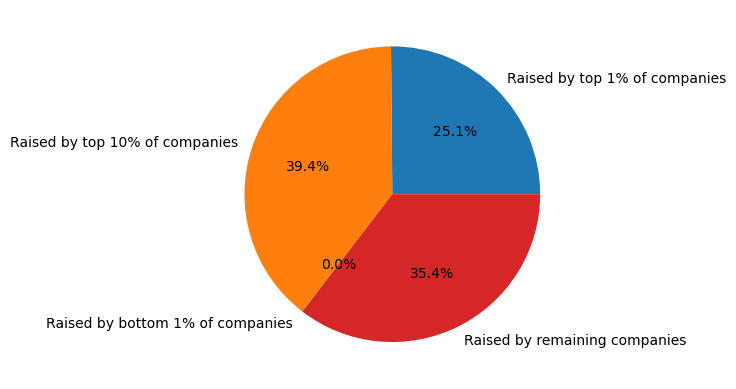

In [43]:
#Plot these porportions
labels = ['Raised by top 1% of companies', 'Raised by top 10% of companies', 'Raised by bottom 1% of companies', 'Raised by remaining companies']
sizes = [porp_top_1perc, porp_top_10perc - porp_top_1perc, porp_bot_10perc, porp_all_else]

figcomp, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show(figcomp)

In [52]:
#find value counts of all categories
total_vcs = df_investment_data['company_category_code'].value_counts().to_frame()
total_vcs_n = round(100 * df_investment_data['company_category_code'].value_counts(normalize=True).to_frame(), 1)
top_1perc_vcs = round(100 * df_investment_data['company_category_code'][:int(np.round(num_companies * .01,0))].value_counts(normalize=True).to_frame(), 1)
top_10perc_vcs = round(100 * df_investment_data['company_category_code'][:int(np.round(num_companies * .1,0))].value_counts(normalize=True).to_frame(), 1)
bot_10perc_vcs = round(100 * df_investment_data['company_category_code'][-int(np.round(num_companies * .1,0)):].value_counts(normalize=True).to_frame(), 1)

#create a DF of all valuecounts across top 1%, 10% and bot 10% to find outliers by category of project.
combined_vcs = pd.concat([total_vcs, total_vcs_n, top_1perc_vcs, top_10perc_vcs, bot_10perc_vcs], axis=1)
# depreciated after refactor
# total_vcs_n = total_vcs.join(total_vcs_n, on='company_category_code', rsuffix='R')
# total_1_vcs = total_vcs_n.join(top_1perc_vcs, on='company_category_code', rsuffix='R')
# total_1_10_vcs = total_1_vcs.join(top_10perc_vcs, on='company_category_code', rsuffix='R')
# combined_vcs = total_1_10_vcs.join(bot_10perc_vcs, on='company_category_code', rsuffix='R')
combined_vcs.columns = ['Total (count)', 'Total (%)', 'Top 1% (%)', 'Top 10% (%)', 'Bot 10% (%)']

#first 13 categories (by total_count) to capture all categories that made up >2%
#Reduce[s size of the table for readability.
combined_vcs.head(13)

,Total (count),Total (%),Top 1% (%),Top 10% (%),Bot 10% (%)
software,1639,16.2,6.7,9.7,13.9
web,1011,10.0,4.8,4.3,15.5
biotech,992,9.8,16.3,22.6,3.9
enterprise,765,7.5,4.8,7.1,4.9
mobile,678,6.7,7.7,4.8,9.0
advertising,527,5.2,NaN,3.7,5.0
cleantech,427,4.2,16.3,8.1,2.2
games_video,409,4.0,3.8,2.4,4.4
ecommerce,380,3.7,3.8,2.9,6.7
hardware,319,3.1,1.9,4.3,3.4


In [56]:
#company categories overrepresented in 1% highest funded
overrepresented1perc = combined_vcs[['Total (count)', 'Total (%)', 'Top 1% (%)']].copy()
overrepresented1perc['overRep'] =  round(overrepresented1perc['Top 1% (%)'] / overrepresented1perc['Total (%)'], 1)
overrepresented1perc.sort_values('overRep', ascending=False, inplace=True)
overrepresented1perc.where(overrepresented1perc['overRep'] > 1).head(16)

,Total (count),Total (%),Top 1% (%),overRep
automotive,25.0,0.2,2.9,14.5
transportation,21.0,0.2,1.0,5.0
nanotech,23.0,0.2,1.0,5.0
cleantech,427.0,4.2,16.3,3.9
travel,59.0,0.6,1.9,3.2
news,64.0,0.6,1.9,3.2
network_hosting,203.0,2.0,5.8,2.9
social,161.0,1.6,2.9,1.8
biotech,992.0,9.8,16.3,1.7
other,137.0,1.4,1.9,1.4


In [59]:
#company categories overrepresented in 10% highest funded
overrepresented10perc = combined_vcs[['Total (count)', 'Total (%)', 'Top 10% (%)']].copy()
overrepresented10perc['overRep10'] =  round(overrepresented10perc['Top 10% (%)'] / overrepresented10perc['Total (%)'], 1)
overrepresented10perc.sort_values('overRep10', ascending=False, inplace=True)
overrepresented10perc.where(overrepresented10perc['overRep10'] > 1).head(12)

,Total (count),Total (%),Top 10% (%),overRep10
nanotech,23.0,0.2,1.0,5.0
biotech,992.0,9.8,22.6,2.3
semiconductor,197.0,1.9,4.1,2.2
automotive,25.0,0.2,0.4,2.0
cleantech,427.0,4.2,8.1,1.9
medical,275.0,2.7,4.8,1.8
network_hosting,203.0,2.0,3.6,1.8
transportation,21.0,0.2,0.3,1.5
hardware,319.0,3.1,4.3,1.4
security,185.0,1.8,2.4,1.3


### Analysis on investors

The top 1% of investors funded 20% of all investments, and the top 10% (inclusive) funded 40% of all investments.

Organizations that funded the most preferred post-IPO funding, these same organizations funded the most per company on average.
These are Comcast, Intel, Time Warner, and Kleiner Perkins Caufield & Byers.

Of these, Kleiner Perkins Caufield & Byers did not fund through post-IPO, they preferred series-c+ investments.
However, KPC&B funded 5 times as many projects. The single largest investment by KPC&B made up 0.13% of their total investments, whereas the other 3 largest investors single largest investment made up 6.67% of their investments.

Interestingly Series-c+ funding rounds had the most overall funding, and post-ipo had the fifth. Series-a funding had the most organizations investing by count, but had some of the smallest investments.


In [60]:
#New query for investor data, nor investment data.
#Ordered by total investment amount
qALLByInvestor = '''
WITH percentile_by_funded AS 
(SELECT investor_name, invested_count, total_funded, single_max,
	   PERCENT_RANK() OVER (ORDER BY total_funded) prnk
  FROM (
		 SELECT investor_name, 
				COUNT(company_name) AS invested_count, 
				SUM(raised_amount_usd / 100) AS total_funded,
				MAX(raised_amount_usd / 100) AS single_max
		  FROM Funding
		 WHERE raised_amount_usd IS NOT NULL
		 GROUP BY investor_name)
		 )
 
SELECT investor_name, invested_count, total_funded, single_max
  FROM percentile_by_funded
 ORDER BY prnk DESC;
 '''

df_investor_data = pd.read_sql(qALLByInvestor, conn)

In [61]:
df_investor_data.head(10)

,investor_name,invested_count,total_funded,single_max
0,Kleiner Perkins Caufield & Byers,2625,7.852478e+08,9500000.0
1,New Enterprise Associates,3066,6.784780e+08,1850000.0
2,Accel Partners,2177,4.530488e+08,3601000.0
3,Goldman Sachs,798,4.462821e+08,15000000.0
4,Sequoia Capital,2450,4.227582e+08,2500000.0
5,Intel,105,4.178440e+08,32000000.0
6,Google,140,4.066160e+08,32000000.0
7,Time Warner,77,4.011000e+08,32000000.0
8,Comcast,63,3.968300e+08,32000000.0
9,Greylock Partners,1680,3.472688e+08,9500000.0


In [62]:
#Constants for calculations to determine market shares
num_investors = df_investor_data.shape[0]

#extract armounts raised aggregated by order of the data (total_raised, most invested as index 0)
top_1perc_investor = round(df_investor_data['total_funded'][:int(np.round(num_companies * .01,0))].sum(), 2)
top_10perc_investor = round(df_investor_data['total_funded'][:int(np.round(num_companies * .1,0))].sum() ,2)
bot_10perc_investor = round(df_investor_data['total_funded'][-int(np.round(num_companies * .1,0)):].sum() ,2)
total_invested = round(df_investor_data['total_funded'].sum() ,2)

#porportion of top 1%
porp_top_1perc = top_1perc_investor / total_invested
#porportion of top 10% INCLUDING top 1%, exclusion handled at plot level
porp_top_10perc = top_10perc_investor  / total_invested
#porportion of bottom 10% 
porp_bot_10perc = bot_10perc_investor / total_invested
#porportion of all but top 10%(including top1%) and bottom 10%
porp_all_else =  (total_invested - top_10perc_investor - bot_10perc_investor) / total_invested

Percent of funds invested
---

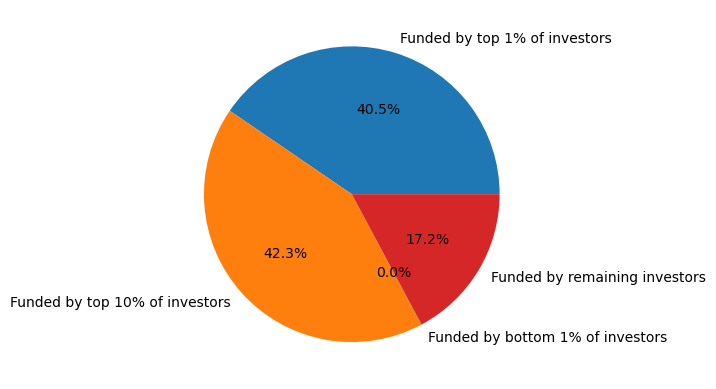

In [63]:
#Plot these porportions
labels = ['Funded by top 1% of investors', 'Funded by top 10% of investors', 'Funded by bottom 1% of investors', 'Funded by remaining investors']
sizes = [porp_top_1perc, porp_top_10perc - porp_top_1perc, porp_bot_10perc, porp_all_else]

figinv, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show(figinv)

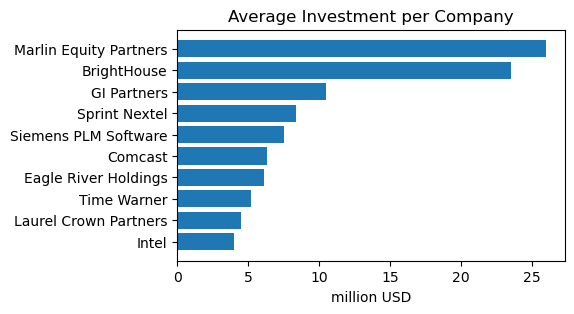

In [64]:
#Find which investors paid most per investment
df_investor_data['per_company'] = df_investor_data['total_funded'] / df_investor_data['invested_count'] / 1000000
df_investment_per_comp = df_investor_data.sort_values('per_company', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(5,3))
investors = df_investment_per_comp['investor_name'].head(10)
y_pos = np.arange(len(investors))
vals = df_investment_per_comp['per_company'].head(10)
ax.barh(y_pos, vals, align='center')
ax.set_yticks(y_pos, labels=investors)
ax.invert_yaxis() #highest investor at top
ax.set_xlabel('million USD')
ax.set_title('Average Investment per Company')
plt.show()


In [65]:
#New query for investor data, nor investment data.
#Ordered by total investment amount
qALLByInvestor = '''
WITH percentile_by_funded AS 
(SELECT investor_name, funding_round_type, invested_count, total_funded, single_max,
	   PERCENT_RANK() OVER (ORDER BY total_funded) prnk
  FROM (
		 SELECT investor_name, funding_round_type,
				COUNT(company_name) AS invested_count, 
				SUM(raised_amount_usd / 100) AS total_funded,
				MAX(raised_amount_usd / 100) AS single_max
		  FROM Funding
		 WHERE raised_amount_usd IS NOT NULL
		 GROUP BY funding_round_type, investor_name)
		 )
 
SELECT investor_name, funding_round_type, invested_count, total_funded, single_max
  FROM percentile_by_funded
 ORDER BY prnk DESC;
 '''

df_funding_type = pd.read_sql(qALLByInvestor, conn)
df_funding_type['per_company'] = df_funding_type['total_funded'] / df_funding_type['invested_count']

df_funding_type.head(10)

,investor_name,funding_round_type,invested_count,total_funded,single_max,per_company
0,Comcast,post-ipo,21,3.934000e+08,32000000.0,1.873333e+07
1,Intel,post-ipo,21,3.934000e+08,32000000.0,1.873333e+07
2,Time Warner,post-ipo,21,3.934000e+08,32000000.0,1.873333e+07
3,Kleiner Perkins Caufield & Byers,series-c+,882,3.768832e+08,9500000.0,4.273052e+05
4,BrightHouse,post-ipo,14,3.290000e+08,32000000.0,2.350000e+07
5,New Enterprise Associates,series-c+,1036,3.049693e+08,1380000.0,2.943719e+05
6,Google,post-ipo,14,2.940000e+08,32000000.0,2.100000e+07
7,Goldman Sachs,venture,210,1.995462e+08,15000000.0,9.502200e+05
8,Kleiner Perkins Caufield & Byers,venture,462,1.940534e+08,4500000.0,4.200290e+05
9,Sequoia Capital,series-c+,910,1.933473e+08,1960000.0,2.124696e+05


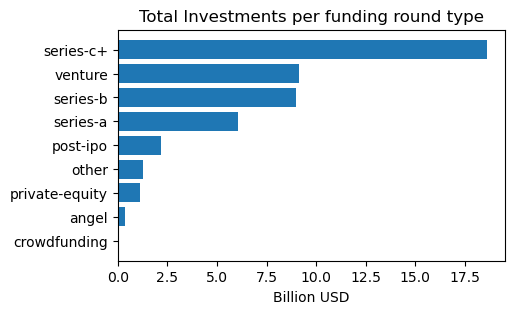

In [66]:
qALLByroundtype = '''
WITH percentile_by_funded AS 
(SELECT funding_round_type, invested_count, total_funded, single_max,
	   PERCENT_RANK() OVER (ORDER BY total_funded) prnk
  FROM (
		 SELECT funding_round_type,
				COUNT(company_name) AS invested_count, 
				SUM(raised_amount_usd / 100) AS total_funded,
				MAX(raised_amount_usd / 100) AS single_max
		  FROM Funding
		 WHERE raised_amount_usd IS NOT NULL
		 GROUP BY funding_round_type)
		 )
 
SELECT funding_round_type, invested_count, total_funded, single_max
  FROM percentile_by_funded
 ORDER BY prnk DESC;
 '''

df_round_type = pd.read_sql(qALLByroundtype, conn)
df_round_type['per_company'] = df_round_type['total_funded'] / df_round_type['invested_count']

df_round_type

#generate the fiure below
fig, ax = plt.subplots(figsize=(5,3))
round_type = df_round_type['funding_round_type']
y_pos = np.arange(len(round_type))
vals = df_round_type['total_funded'] / 1000000000
ax.barh(y_pos, vals, align='center')
ax.set_yticks(y_pos, labels=round_type)
ax.invert_yaxis() #highest funded at top
ax.set_xlabel('Billion USD')
ax.set_title('Total Investments per funding round type')
plt.show()

Investment Analysis
---
The top 1% of investors funded 20% of all investments, and the top 10% (inclusive) funded 40% of all investments.

Organizations that funded the most preferred post-IPO funding, these same organizations funded the most per company on average.
These are Comcast, Intel, Time Warner, and Kleiner Perkins Caufield & Byers.

Of these, Kleiner Perkins Caufield & Byers did not fund through post-IPO, they preferred series-c+ investments.
However, KPC&B funded 5 times as many projects. The single largest investment by KPC&B made up 0.13% of their total investments, whereas the other 3 largest investors single largest investment made up 6.67% of their investments.

Interestingly Series-c+ funding rounds had the most overall funding, and post-ipo had the fifth. Series-a funding had the most organizations investing by count, but had some of the smallest investments.

Company Analysis
---
The top 1% of companies funded raised 25% of all investments<br>
The top 10% (inclusive) raised 2/3 of all investments.<br>

Automotive, transportation, nanotech, cleantech, travel, and news very overrepresented (>300%) in the 1% of companies most funded.<br>
Nanotech was the only category very overrepresented in the top 10% most funded companies.



In [67]:
conn.commit()
conn.close()

Other SQL queries
---
Below is a family of queries that were useful in developing this analysis.

In [ ]:
conn.rollback()

In [68]:
#Fully delete the table from the DB
#Used when the sqlite3 injected all text columns and the python cleaning had to be improved[s
conn = sqlite3.connect('crunchbase-DQ')
cur = conn.cursor()
q= "DROP TABLE Funding;"
cur.execute(q)
cur.execute("FULL VACUUM")

OperationalError: database is locked